# Quicklook Map Example


### Load in the libraries that we'll use below:

In [1]:
import sys
from os.path import *
import os

from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

from pylab import figure, cm


import astropy.time
import astropy.units as u
from astropy.coordinates import get_sun

import sunpy.map
from sunpy import sun

import numpy as np
%matplotlib inline



/Users/bwgref/science/local/anaconda/lib/python3.5/site-packages/glymur/config.py:171: UserWarning: Neither the openjp2 nor the openjpeg library could be loaded.  
  warnings.warn(msg)


In [16]:
import nustar_pysolar as nustar_test


### Load in the data

In [5]:
infile = 'data/Sol_16208/20201001001/event_cl/nu20201001001A06_chu12_N_cl_sunpos.evt'

In [6]:
hdulist = fits.open(infile)

evtdata=hdulist[1].data
hdr = hdulist[1].header

print("Loaded: ", len(evtdata['X']), " counts.")
print("Effective exposure: ", hdr['EXPOSURE'], ' seconds')
hdulist.close()

Loaded:  728843  counts.
Effective exposure:  30.8255227372596  seconds


### Do some quick filtering

### Construct a map object compatible with sunpy

In [13]:
# Header keywords
for field in hdr.keys():
    if field.find('TYPE') != -1:
        if hdr[field] == 'X':
            print(hdr[field][5:8])
            xval = field[5:8]
        if hdr[field] == 'Y':
            print(hdr[field][5:8])
            yval = field[5:8]
            
min_x= hdr['TLMIN'+xval]
min_y= hdr['TLMIN'+yval]
max_x= hdr['TLMAX'+xval]
max_y= hdr['TLMAX'+yval]

delx = hdr['TCDLT'+xval]
dely = hdr['TCDLT'+yval]

x = evtdata['X'][goodinds]
y = evtdata['Y'][goodinds]
met = evtdata['TIME'][goodinds]*u.s
mjdref=hdr['MJDREFI']
mid_obs_time = astropy.time.Time(mjdref*u.d+met.mean(), format = 'mjd')

# Use the native binning for now

# Assume X and Y are the same size
resample = 5.0
scale = delx * resample
bins = (max_x - min_x) / (resample)

H, yedges, xedges = np.histogram2d(y, x, bins=bins, range = [[min_y,max_y], [min_x, max_x]])

'2016-07-26 19:39:07.011'

In [27]:
dict_header = {
    "DATE-OBS": mid_obs_time.iso,
    "CDELT1": scale,
    "NAXIS1": bins,
    "CRVAL1": 0.,
    "CRPIX1": bins*0.5,
    "CUNIT1": "arcsec",
    "CTYPE1": "HPLN-TAN",
    "CDELT2": scale,
    "NAXIS2": bins,
    "CRVAL2": 0.,
    "CRPIX2": bins*0.5 + 0.5,
    "CUNIT2": "arcsec",
    "CTYPE2": "HPLT-TAN",
    "HGLT_OBS": 0,
    "HGLN_OBS": 0,
    "RSUN_OBS": sun.solar_semidiameter_angular_size(mid_obs_time).value,
    "RSUN_REF": sun.constants.radius.value
}
#    "DSUN_OBS": sun.sunearth_distance(mid_obs_time) * sun.constants.au.value
# For some reason the DSUN_OBS crashed the save...

header = sunpy.map.MapMeta(dict_header)

nustar_map = sunpy.map.Map(H, header)
nustar_map.plot_settings['norm'] = colors.LogNorm(0.01, nustar_map.max())
nustar_map.plot_settings['cmap'] = cm.get_cmap('BrBG')


# # Make the new filename:
(sfile, ext)=splitext(infile)
outfile=sfile+'_map.fits'

# Remove output file if necessary
if isfile(outfile):
    print(outfile, 'exists! Removing old version...')
    os.remove(outfile)

nustar_map.save(outfile, filetype='auto')


### Take a peak and see what you've got.

/Users/bwgref/science/local/anaconda/lib/python3.5/site-packages/sunpy/map/mapbase.py:1590: Warning: WCSAxes is installed but not being used. Plots may not have the expected behaviour.
  Warning)


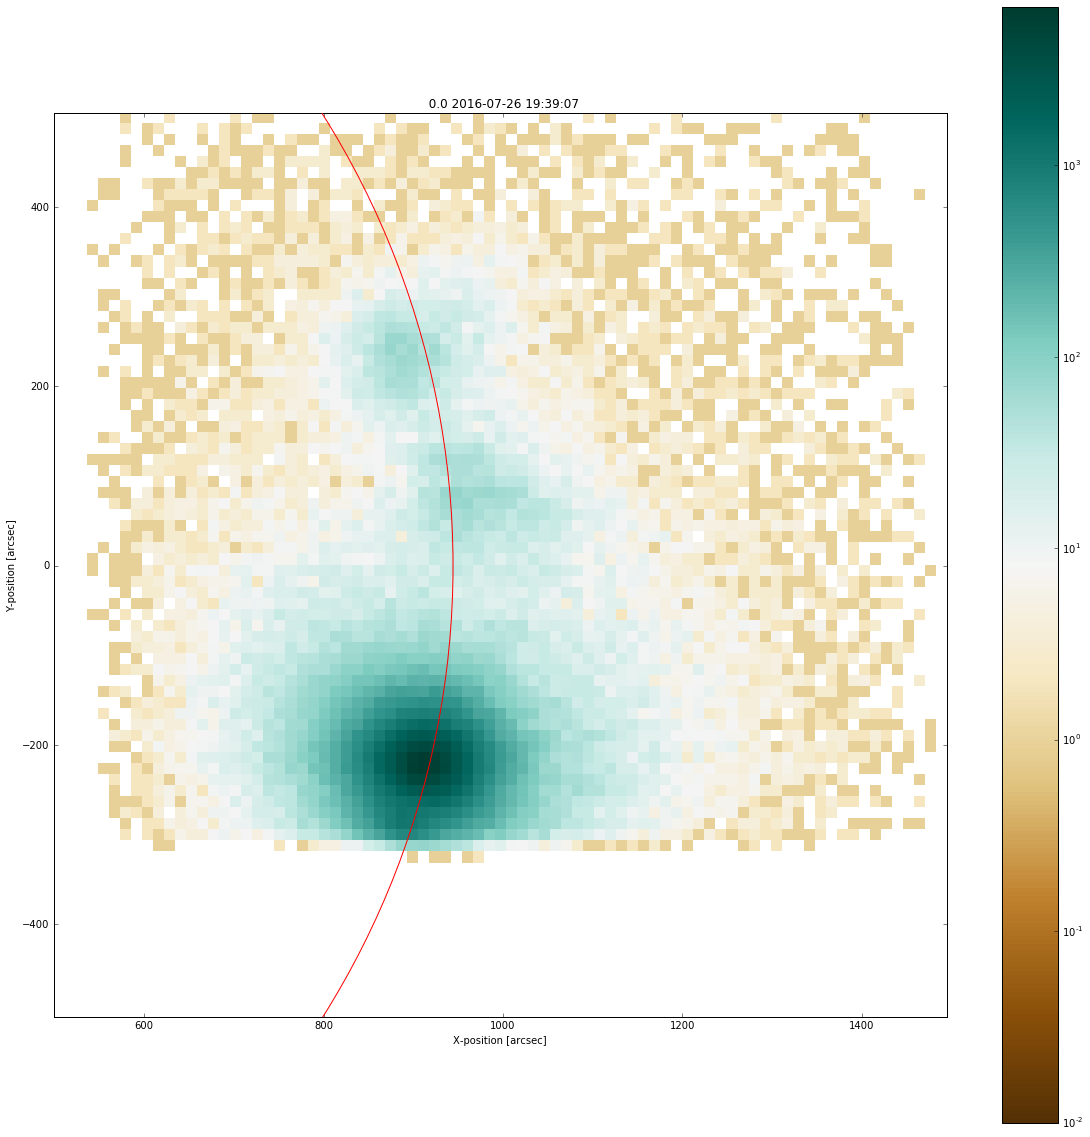

In [25]:
rangex = u.Quantity([500*u.arcsec, 1500 * u.arcsec])
rangey = u.Quantity([-500 * u.arcsec, 500 * u.arcsec])

nustar_submap = nustar_map.submap(rangex, rangey)
plt.subplots(figsize=(20, 20))


nustar_submap.plot()
plt.colorbar()
nustar_submap.draw_limb(color='r')
